# **Recurrent Neural Network - Long Short Term Memory**

This notebook implements Long Short Term Memory(LSTM), one of famous RNN architectures, to create a text classification model as a simple baseline for T-Brain competition.

## Long Short Term Memory

In [1]:
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # Embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :]
        x = self.classifier(x)
        return x

## T-Brain Simple Baseline - LSTM

### Preparing

> First, please download the [dataset](https://gitlab.com/kvnkuol/bestline/-/archive/jc/bestline-jc.zip?path=JC/data) as a .zip file from GitLab prepared by J.C. as well as the official data from T-Brain. The following code will extract the .zip file and assign the path of data.

In [2]:
%%capture
#!unzip -o bestline-jc-JC-data.zip

RAW_DATA_PATH = 'JC_tbrain_train_final_0701.csv'    # T-Brain
DATA_PATH = 'bestline-jc-JC-data/JC/data'           # J.C.

### Preprocessing

> Loading data with `codecs` and `BeautifulSoup`.

In [3]:
import os
import pandas as pd
import codecs
from bs4 import BeautifulSoup

In [4]:
def load_data(crawled_data_path, original_data_path):
    
    raw_df = pd.read_csv(original_data_path) # Data provided by T-Brain

    news = []   # News crawled by J.C.
    labels = [] # Labels, AML related or not.

    for file in sorted(os.listdir(crawled_data_path)):
        # Get labels. Hint: Empty 'name' contains two characters '[]'.
        news_ID = int(file.split('_')[0])
        if len(raw_df.loc[news_ID-1, 'name']) > 2:
            labels.append(1)
        else:
            labels.append(0)

        # Get news content.
        f = codecs.open(DATA_PATH + '/' + file, 'r', 'utf-8')
        content = BeautifulSoup(f.read()).get_text()
        news.append(content)

    return news, labels

In [5]:
news, labels = load_data(crawled_data_path=DATA_PATH, original_data_path=RAW_DATA_PATH)

#### Word Segmentation
> Before embeding words into vectors, we have to segment words. Here we use [`jieba`](https://github.com/fxsjy/jieba) to segment words.

In [6]:
import jieba

def word_seg(articles):
    articles_seg = []
    for article in articles:
        words = jieba.cut(article, cut_all=False)
        articles_seg.append([word for word in words])
    return articles_seg

In [7]:
news = word_seg(news)
print(news[0])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.664 seconds.
Prefix dict has been built successfully.


['量化', '交易', '追求', '絕對', '報酬', '有效', '對', '抗牛', '熊市', '近年', '來', '投資', '市場', '波動', '越來', '越', '明顯', '，', '追求', '低波動', '、', '絕對', '報酬', '的', '量化', '交易', '備受', '注目', '。', '專家', '表示', '，', '採用', '量化', '交易', '策略', '投資台', '股', '，', '不管', '是', '處', '於', '多頭', '或是', '空頭', '市場', '，', '績效', '及', '波動度', '均', '可領', '跑', '大盤', '，', '甚至', '比國內', '投資台', '股', '的', '股票', '型基金', '及', 'ETF', '的', '波動率', '還低', '，', '表現', '也', '更', '為', '穩定', '。', '大數據', '時代來', '臨', '，', '風行', '歐美', '50', '年', '的', '量化', '交易', '儼然', '成為', '顯學', '，', '台灣', '亦', '開始', '重視此', '一', '趨勢', '發展', '，', '也', '因此', '，', '中華機', '率統', '計學會', '及', '台北', '科技', '大學', '管理', '學院', '攜手', '主辦', '，', '並由元', '大期貨', '、', '摩根', '亞太', '量化', '交易', '等', '公司', '擔任', '協辦', '單位', '，', '今', '(', '7', '/', '5', ')', '日舉', '辦', '「', '時間', '序列', '與', '量化', '交易', '研討會', '」', '，', '就', '目前', '熱門', '的', '量化', '交易', '、', '智能', '投資', '等', '相關', '議題', '進行', '研討', '。', '越來', '越', '多', '的', '基金', '公司', '重視', '量化', '交易', '，', '全球', '規模', '較', '大', '的', '避險', '基金'

#### Word Embedding
> Using `word2vec` of `gensim.models` to train the word embedding model of word to vector.

In [8]:
from gensim.models import word2vec

def train_word2vec(x):
    # Training word embedding of word to vector.
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1)
    return model

In [9]:
'''
print("Training word embedding model ...")
model = train_word2vec(news)
print("saving model ...")
model.save('w2v.model')
print("Model saved!")
'''

'\nprint("Training word embedding model ...")\nmodel = train_word2vec(news)\nprint("saving model ...")\nmodel.save(\'w2v.model\')\nprint("Model saved!")\n'

#### Data Preprocessing

In [10]:
from torch import nn
import torch
from torch.utils import data
from gensim.models import Word2Vec

In [11]:
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.

class Preprocess():

    def __init__(self, news, news_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.news = news
        self.news_len = news_len
        self.word2idx = {}
        self.idx2word = []
        self.embedding_matrix = []

    def get_w2v_model(self):
        # Loading the trained word to vector model.
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size

    def add_embedding(self, word):
        # 把 word 加進 embedding，並賦予他一個隨機生成的 representation vector
        # word 只會是 "<PAD>" 或 "<UNK>"
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)

    def make_embedding(self, load=True):
        print("Get embedding ...")
        # Loading trained Word2vec word embedding
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError

        # Create a word2idx dictionary
        # Create an idx2word list
        # Create a word2vector list
        for i, word in enumerate(self.embedding.wv.vocab):
            #print('get words #{}'.format(i+1), end='\r')
            #e.g. self.word2index['he'] = 1 
            #e.g. self.index2word[1] = 'he'
            #e.g. self.vectors[1] = 'he' vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding[word])
        #print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)

        # Adding "<PAD>" and "<UNK>" into embedding.
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix

    def pad_sequence(self, article):
        # Making each news article to have the same length.
        if len(article) > self.news_len:
            article = article[:self.news_len]
        else:
            pad_len = self.news_len - len(article)
            for _ in range(pad_len):
                article.append(self.word2idx["<PAD>"])
        assert len(article) == self.news_len
        return article

    def news_word2idx(self):
        # Transform words in news into index
        news_list = []
        for i, article in enumerate(self.news):
            print('article count #{}'.format(i+1), end='\r')
            article_idx = []
            for word in article:
                if (word in self.word2idx.keys()):
                    article_idx.append(self.word2idx[word])
                else:
                    article_idx.append(self.word2idx["<UNK>"])
            # 將每篇文章變成一樣的長度
            article_idx = self.pad_sequence(article_idx)
            news_list.append(article_idx)
        return torch.LongTensor(news_list)

    def labels_to_tensor(self, y):
        # 把 labels 轉成 tensor
        y = [int(label) for label in y]
        return torch.LongTensor(y)

# Creating funcions, '__init__', '__getitem__' and '__len__', for dataloader.
class TBrainDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

# Data augmentation
def augment(x, y, n):
    # n = Number of copies.
    for i, label in enumerate(y):
        if label == 1:
            for j in range(n):
                x = torch.cat([x, x[i].unsqueeze(0)], dim=0)
                y = torch.cat([y, y[i].unsqueeze(0)], dim=0)
    return x, y

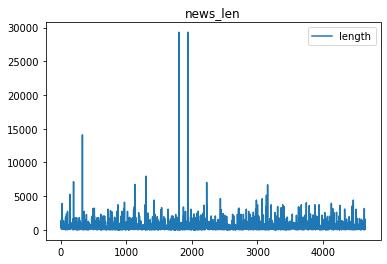

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

news_len = []
for article in news:
    news_len.append(len(article))

plt.title("news_len")
plt.plot(news_len, label='length')
plt.legend(loc='best')
plt.show()

In [13]:
%%capture
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.

# Hyper-parameters for creating datatloader
batch_size = 256    #128
article_len = 500   # Length of article
w2v_path = 'w2v.model' # Path of trained word to vec model

# Preprocessing
preprocess = Preprocess(news, article_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.news_word2idx()
y = preprocess.labels_to_tensor(labels)

# Deviding data to training data and validation data
X_train, X_val, X_test, y_train, y_val, y_test = train_x[:3000], train_x[3000:4000], train_x[4000:], y[:3000], y[3000:4000], y[4000:]
X_train, y_train = augment(X_train, y_train, 4)

# Create dataset for dataloader.
train_dataset = TBrainDataset(X=X_train, y=y_train)
val_dataset = TBrainDataset(X=X_val, y=y_val)
test_dataset = TBrainDataset(X=X_test, y=y_test)

# Transforming dataset to batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [14]:
# Get information from dataset
train_aml=0
for i in train_dataset.label:
    if i == 1:
        train_aml+=1

print("Number of training data: {}".format(len(train_dataset.label)))
print("Number of AML related news: {}".format(train_aml))
print("Percent of AML related news: {:.2f}%".format((train_aml)/len(train_dataset.label)*100))

val_aml=0
for i in val_dataset.label:
    if i == 1:
        val_aml+=1

print("\nNumber of validation data: {}".format(len(val_dataset.label)))
print("Number of AML related news: {}".format(val_aml))
print("Percent of AML related news: {:.2f}%".format((val_aml)/len(val_dataset.label)*100))

test_aml=0
for i in test_dataset.label:
    if i == 1:
        test_aml+=1

print("\nNumber of Testing data: {}".format(len(test_dataset.label)))
print("Number of AML related news: {}".format(test_aml))
print("Percent of AML related news: {:.2f}%".format((test_aml)/len(test_dataset.label)*100))

Number of training data: 3844
Number of AML related news: 1055
Percent of AML related news: 27.45%

Number of validation data: 1000
Number of AML related news: 65
Percent of AML related news: 6.50%

Number of Testing data: 647
Number of AML related news: 52
Percent of AML related news: 8.04%


### Training

In [15]:
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.
import os
import torch
import argparse
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

In [16]:
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.

# train.py
# 這個 block 是用來訓練模型的

def evaluation(outputs, labels):
    # outputs => probability (float)
    # labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於 0.5 為正面
    outputs[outputs<0.5] = 0 # 小於 0.5 為負面

    # Confusion matrix
    tn, fp = 0, 0   # True Negtive, False Positive
    fn, tp = 0, 0   # False Negtive, True Positive
    for i in range(len(outputs)):
        if outputs[i]==1:
            if outputs[i].item() == labels[i].item():
                tp += 1
            else:
                fp += 1
        else:
            if outputs[i].item() == labels[i].item():
                tn += 1
            else:
                fn += 1

    # Precision
    if tp+fp == 0:
        prec = 0
    else:
        prec = tp/(tp+fp)

    # Recall
    if tp+fn == 0:
        rec = 0
    else:
        rec = tp/(tp+fn)
    
    # F1 Score
    if prec+rec == 0:
        f1 = 0
    else:
        f1 = 2 * (prec*rec/(prec+rec))

    # Number of correct predictions
    correct = torch.sum(torch.eq(outputs, labels)).item()

    return correct, f1

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):

    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))

    model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數
    
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # 將模型的參數給 optimizer，並給予適當的 learning rate

    total_loss, total_acc, best_f1 = 0, 0, 0
    train_loss, train_f1, val_loss, val_f1 = [], [], [], []

    for epoch in range(n_epoch):
        total_loss, total_acc, total_f1 = 0, 0, 0

        # Training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
            labels = labels.to(device, dtype=torch.float) # device為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
            optimizer.zero_grad() # 由於 loss.backward() 的 gradient 會累加，所以每次餵完一個 batch 後需要歸零
            outputs = model(inputs) # 將 input 餵給模型
            outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()

            loss = criterion(outputs, labels) # 計算此時模型的 training loss
            loss.backward() # 算 loss 的 gradient
            optimizer.step() # 更新訓練模型的參數

            correct, f1 = evaluation(outputs, labels) # 計算此時模型的 training accuracy

            
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            total_f1 += f1

            #print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        
        train_loss.append(total_loss/t_batch)
        train_f1.append(total_f1/t_batch)
        print('\nEpoch: {}'.format(epoch+1))
        print('Train | Loss:{:.5f} Acc: {:.3f} F1 Score: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100, total_f1/t_batch))

        # Validation
        model.eval() # 將 model 的模式設為 eval，這樣 model 的參數就會固定住
        with torch.no_grad():
            total_loss, total_acc, total_f1 = 0, 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
                labels = labels.to(device, dtype=torch.float) # device 為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
                outputs = model(inputs) # 將 input 餵給模型
                outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
                loss = criterion(outputs, labels) # 計算此時模型的 validation loss
                correct, f1 = evaluation(outputs, labels) # 計算此時模型的 validation accuracy

                total_acc += (correct / batch_size)
                total_loss += loss.item()
                total_f1 += f1

            val_loss.append(total_loss/v_batch)
            val_f1.append(total_f1/v_batch)
            print("Valid | Loss:{:.5f} Acc: {:.3f} F1 Score: {:.3f}".format(total_loss/v_batch, total_acc/v_batch*100, total_f1/v_batch))

            # 如果 validation 的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用
            if total_f1 > best_f1:
                best_f1 = total_f1
                #torch.save(model, "{}/val_acc_{:.3f}.model".format(model_dir,total_acc/v_batch*100))
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with f1 {:.3f}'.format(total_f1/v_batch))

        print('-----------------------------------------------')
        model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數（因為剛剛轉成 eval 模式）

    return train_loss, train_f1, val_loss, val_f1

In [17]:
# Ref: HW4 in the course ML2020 by Hung-yi Lee in NTU.

# Checking if gpu is availible.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining hyper-parameters
epoch = 100
lr = 0.001

fix_embedding = True # Fixing embedding during training
model_dir = os.getcwd() # Model directory for checkpoint model

# Creating model
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=3, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device)

# Starting training
train_loss, train_f1, val_loss, val_f1 = training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)


start training, parameter total:7950751, trainable:603751


Epoch: 1
Train | Loss:0.67687 Acc: 54.725 F1 Score: 0.146
Valid | Loss:0.46576 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epoch: 2
Train | Loss:0.62467 Acc: 69.725 F1 Score: 0.000
Valid | Loss:0.43532 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epoch: 3
Train | Loss:0.58966 Acc: 69.725 F1 Score: 0.000
Valid | Loss:0.37674 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epoch: 4
Train | Loss:0.56556 Acc: 69.725 F1 Score: 0.000
Valid | Loss:0.39422 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epoch: 5
Train | Loss:0.56223 Acc: 69.725 F1 Score: 0.000
Valid | Loss:0.40331 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epoch: 6
Train | Loss:0.56349 Acc: 69.725 F1 Score: 0.000
Valid | Loss:0.34872 Acc: 93.500 F1 Score: 0.000
-----------------------------------------------

Epo

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch: 25
Train | Loss:0.34504 Acc: 72.400 F1 Score: 0.279
Valid | Loss:0.21539 Acc: 79.900 F1 Score: 0.382
saving model with f1 0.382
-----------------------------------------------

Epoch: 26
Train | Loss:0.37221 Acc: 80.100 F1 Score: 0.750
Valid | Loss:0.18664 Acc: 86.400 F1 Score: 0.473
saving model with f1 0.473
-----------------------------------------------

Epoch: 27
Train | Loss:0.42437 Acc: 75.275 F1 Score: 0.619
Valid | Loss:0.25197 Acc: 79.900 F1 Score: 0.389
-----------------------------------------------

Epoch: 28
Train | Loss:0.35205 Acc: 83.650 F1 Score: 0.767
Valid | Loss:0.21156 Acc: 93.900 F1 Score: 0.548
saving model with f1 0.548
-----------------------------------------------

Epoch: 29
Train | Loss:0.39337 Acc: 84.125 F1 Score: 0.747
Valid | Loss:0.25255 Acc: 93.700 F1 Score: 0.496
-----------------------------------------------

Epoch: 30
Train | Loss:0.42447 Acc: 80.325 F1 Score: 0.614
Valid | Loss:0.23712 Acc: 93.800 F1 Score: 0.475
-------------------------

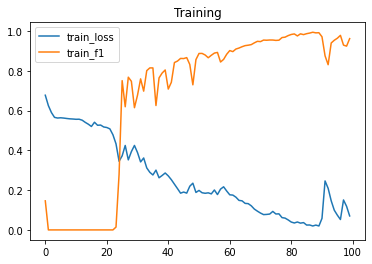

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Training")
plt.plot(train_loss, label='train_loss')
plt.plot(train_f1, label='train_f1')
plt.legend(loc='best')
plt.show()

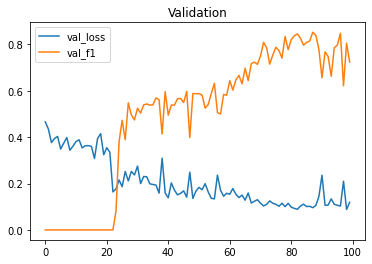

In [19]:
plt.title("Validation")
plt.plot(val_loss, label='val_loss')
plt.plot(val_f1, label='val_f1')
plt.legend(loc='best')
plt.show()

### Testing


In [20]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = False, num_workers = 8)
test_size = len(test_dataset)
test_model = torch.load("{}/ckpt.model".format(model_dir))

In [21]:
print(test_size)

647


In [22]:
# Testing
test_model.eval() # 將 model 的模式設為 eval，這樣 model 的參數就會固定住
criterion = nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
with torch.no_grad():
    total_loss, total_acc, total_f1 = 0, 0, 0
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
        labels = labels.to(device, dtype=torch.float) # device 為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
        outputs = test_model(inputs) # 將 input 餵給模型

        #outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
        loss = criterion(outputs, labels) # 計算此時模型的 testing loss
        correct, f1 = evaluation(outputs, labels) # 計算此時模型的 testing accuracy

        if correct==1:
            print(loss, labels)

        total_acc += (correct / test_size)
        total_loss += loss.item()
        total_f1 += f1

    val_loss.append(total_loss/test_size)
    val_f1.append(total_f1/test_size)
    print("Valid | Loss:{:.5f} Acc: {:.3f}% F1 Score: {:.3f}".format(total_loss/test_size, total_acc/test_size*100, total_f1/test_size))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([647])) that is different to the input size (torch.Size([647, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Valid | Loss:0.00013 Acc: 85.607% F1 Score: 0.001


## Acknowledge

## References

### Courses
* [Machine Learning (2020,Spring)](http://speech.ee.ntu.edu.tw/~tlkagk/courses_ML20.html) by Hung-yi Lee in NTU.

### Blogs
* [進入 NLP 世界的最佳橋樑：寫給所有人的自然語言處理與深度學習入門指南](https://leemeng.tw/shortest-path-to-the-nlp-world-a-gentle-guide-of-natural-language-processing-and-deep-learning-for-everyone.html) by LeeMeng